In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# **Load data**

In [2]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving data_HW3.csv to data_HW3.csv


In [3]:
newData = pd.read_csv(filename)

Data preperation Pipline

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def categoriesUpdate(data):
  copy_of_data_set = data.copy()

  #drop of all irellevent columns
  copy_of_data_set.drop('patient_id', inplace=True, axis=1)

  #creating spacial porperty category
  copy_of_data_set['SpecialProperty'] = copy_of_data_set['blood_type'].isin(["O+", "B+"])
  copy_of_data_set.drop('blood_type', inplace=True, axis=1)
  copy_of_data_set['SpecialProperty'] = copy_of_data_set['SpecialProperty'].astype(int)


  #transform gender to boolean
  sex_dict={'M': 0, 'F': 1}
  copy_of_data_set.sex = [sex_dict[i] for i in copy_of_data_set.sex]
  copy_of_data_set.sex = copy_of_data_set.sex.astype(int)


  return copy_of_data_set

def normalizationByStandartMethod(train, data):
  standard_cols = ['PCR_01', 'PCR_02','PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'weight', 'happiness_score', 'conversations_per_day',  'sugar_levels', 'household_income',
 'sport_activity', 'num_of_siblings']
  scaler = StandardScaler()
  scaler.fit(train[standard_cols]) # 1. maybe needs .fit_transform() 2. train_data shouldnt be changed [also this is not returned so doesnt rly mtr]
  data[standard_cols]=scaler.transform(data[standard_cols]) # Function should output the new "data", should be changed according to mentioned above

def normalizationByMinMaxtMethod(train, data):
  min_max_cols = ['PCR_03', 'PCR_10', 'age']
  scaler = MinMaxScaler((-1,1))
  scaler.fit(train[min_max_cols])
  data[min_max_cols]=scaler.transform(data[min_max_cols])

def prepare_data(training_data, new_data):
  new_train_set = categoriesUpdate(training_data)
  new_data_copied = categoriesUpdate(new_data)

  normalizationByStandartMethod(new_train_set, new_data_copied)
  normalizationByMinMaxtMethod(new_train_set, new_data_copied)
  median_house_income = new_data_copied['household_income'].median()
  new_data_copied['household_income'].fillna(median_house_income, inplace=True)

  return new_data_copied


In [5]:
train_set, test_set = train_test_split(newData, test_size=0.2, random_state=8)

In [6]:
train_df_prepared = prepare_data(train_set, train_set)
test_df_prepared = prepare_data(train_set, test_set)


In [7]:
train_df_prepared.head()

,age,sex,weight,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,...,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level,SpecialProperty
1116,-0.220779,1,1.044658,"('57.30185', '39.85331')",-1.330094,-1.428479,-0.219232,-0.555546,1.391968,-0.154078,...,-0.736588,-0.890317,1.350969,-1.187817,-0.342235,-0.578670,0.709066,0.606766,0.253947,0
431,-0.038961,1,0.376166,"('51.19139', '6.51352')",0.999318,0.697234,-0.143413,-0.555546,0.925647,-0.154078,...,0.514008,1.989359,-0.097572,0.966121,-0.763569,1.620867,-0.165771,0.192102,0.706689,0
787,-0.740260,0,-1.480186,"('60.02427', '30.28491')",0.222847,1.405804,-0.160909,-0.213250,-2.163729,-1.024575,...,-0.665734,-0.130127,2.985657,1.102527,-0.915022,-0.930548,0.968573,0.282952,-0.107040,1
687,-0.818182,1,-1.233358,"('-21.41222', '-42.19667')",0.222847,-0.719908,-0.155077,1.498229,-2.105439,-0.154078,...,-0.656387,-0.020204,0.038438,-0.306928,-1.064978,2.289072,1.022344,-0.382703,0.055830,0
1170,-0.792208,0,-1.279639,"('16.75973', '-93.11308')",0.999318,0.697234,-0.219232,-0.555546,-1.930568,-0.154078,...,0.849297,1.334386,-0.040108,0.581033,0.777855,-0.602195,-0.205669,-0.614843,0.099671,0


# **Section 1: Linear regression implementation**

In [8]:
from os import get_blocking
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        predictions = X.dot(w) + b
        loss = np.mean((predictions - y) ** 2)

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        num_of_samples = X.shape[0]
        errors = y-(X.dot(w) + b)
        g_w = -2 * (X.T.dot(errors)) / num_of_samples
        g_b = -2 * np.sum(errors) / num_of_samples

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr *g_w
            self.b = self.b - self.lr *g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = X.dot(self.w) + self.b
        return y_pred

## **Q2**

In [9]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


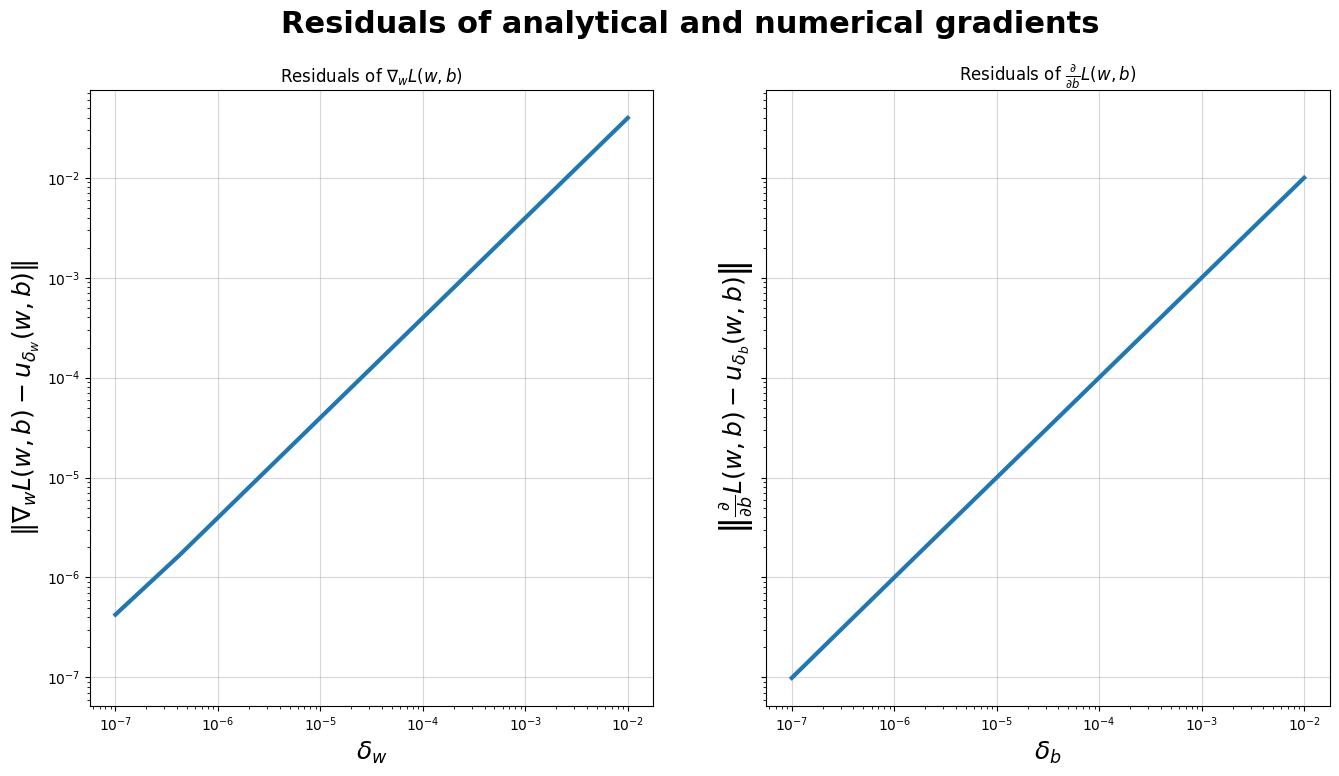

In [10]:
train_subset, val_subset = train_test_split(train_df_prepared, test_size=0.2, random_state=8)
features = train_df_prepared.columns.tolist()
features.remove('contamination_level')
features.remove('current_location')
features.remove('pcr_date')

X_train = train_subset[features].values
y_train = train_subset['contamination_level'].values
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2,9))

## **Q3**

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 0.0755986433047393, Best validation loss = 0.08126771900623787
lr size = 1e-08, Best train loss = 0.07559464835901535, Best validation loss = 0.08126356704575499
lr size = 1e-07, Best train loss = 0.07555471286931698, Best validation loss = 0.08122206178993158
lr size = 1e-06, Best train loss = 0.07515675119992951, Best validation loss = 0.08080844056261116
lr size = 1e-05, Best train loss = 0.07131300078127216, Best validation loss = 0.07681186157363772
lr size = 0.0001, Best train loss = 0.0436023376470872, Best validation loss = 0.047905674936666
lr size = 0.001, Best train loss = 0.007625110124496217, Best validation loss = 0.010133674875294789
lr size = 0.01, Best train loss = 0.006917397252411456, Best validation loss = 0.009372524400616701
lr size = 0.1, Best train loss = 0.0070591029958486816, Best validation loss = 0.009145063441041774


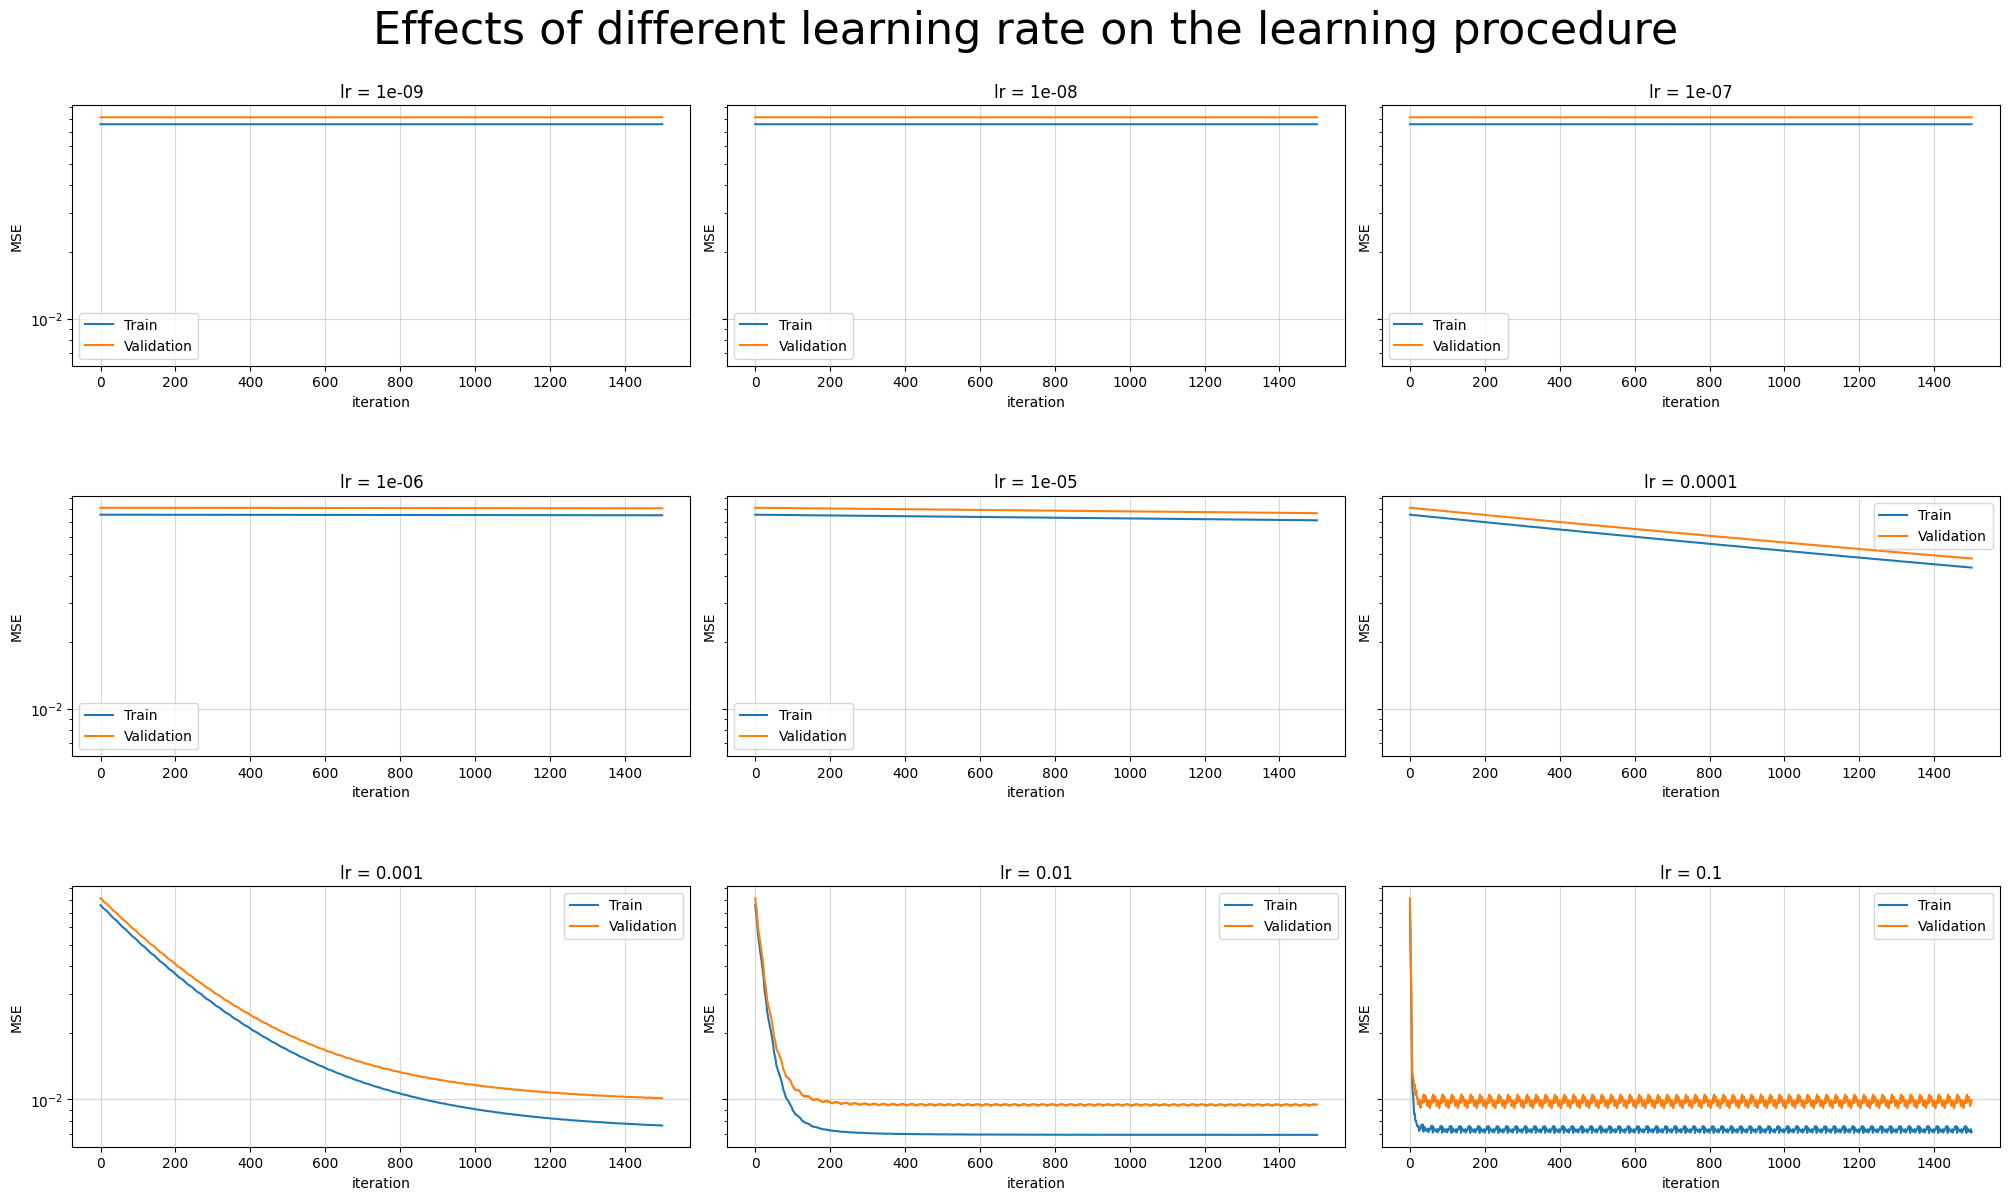

In [12]:
X_val = val_subset[features].values
y_val = val_subset['contamination_level'].values
test_lr(X_train, y_train, X_val, y_val, 'Effects of different learning rate on the learning procedure')

# **Section 2: Evaluation and Baseline**

## **Q4**

In [13]:
from sklearn.model_selection import cross_validate

In [14]:
errors_data = pd.DataFrame(columns=['section', 'Train MSE', 'Validation MSE'])

In [15]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy='mean')
scores = cross_validate(dummy_regressor, X_train, y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
train_MSE =np.mean(scores['train_score'])
val_MSE = np.mean(scores['test_score'])
errors_data.loc["Dummy"] = ['2', abs(train_MSE), abs(val_MSE)]
dummy_reg_val_err = np.mean(scores['test_score'])

In [16]:
errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.066927,0.067375


In [17]:
X_train_all = train_df_prepared[features].values
y_train_all = train_df_prepared['contamination_level'].values

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train_all, y_train_all)

DummyRegressor()

## **Q5**

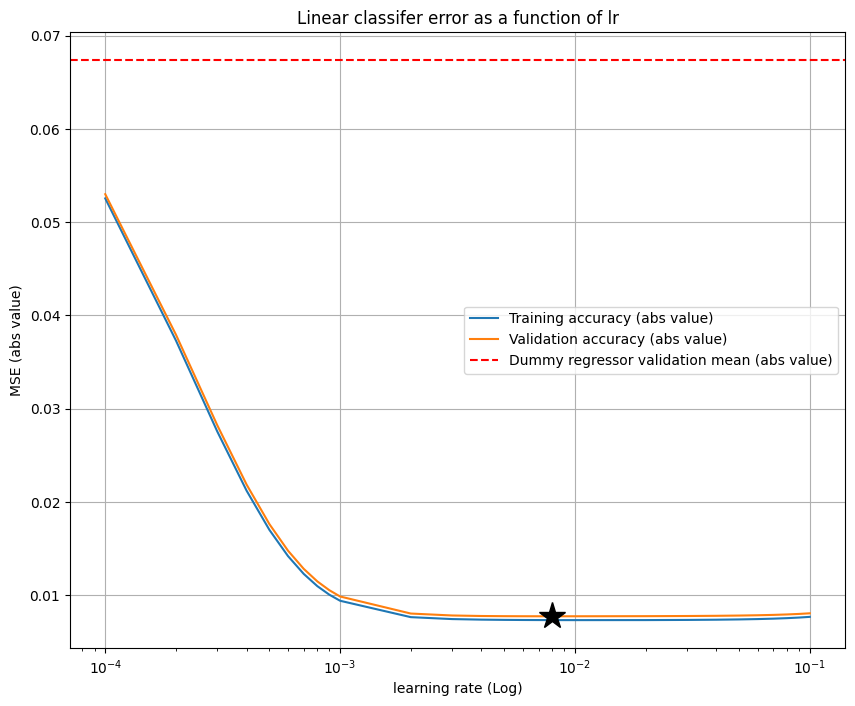

In [18]:
from matplotlib.pyplot import semilogx
poss_lr_values = np.linspace(0.0001, 0.001, 10)
poss_lr_values = np.append(poss_lr_values, np.linspace(0.002, 0.01, 9))
poss_lr_values = np.append(poss_lr_values, np.linspace(0.02, 0.1, 9))

best_train, best_val, best_lr = -100, -100, 0
scores_train, scores_val =[], []
for i in poss_lr_values:
  cur_linear_reggressor = LinearRegressor(lr = i)
  scores = cross_validate(cur_linear_reggressor, X_train_all, y_train_all, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_MSE = np.mean(scores['train_score'])
  val_MSE = np.mean(scores['test_score'])
  scores_train.append(train_MSE)
  scores_val.append(val_MSE)
  if val_MSE > best_val:
    best_train = train_MSE
    best_val = val_MSE
    best_lr = i

cv_stat = pd.DataFrame(data={'lr': poss_lr_values})
cv_stat['Train MSE'] = np.array(scores_train).tolist()
cv_stat['Validation MSE'] =np.array(scores_val).tolist()
min_val_error = np.argmin(abs(cv_stat['Validation MSE']))

fig = plt.figure(figsize=(10, 8))
plt.semilogx(cv_stat['lr'], abs(cv_stat['Train MSE']), '-', label="Training accuracy (abs value)")
plt.semilogx(cv_stat['lr'], abs(cv_stat['Validation MSE']), '-', label="Validation accuracy (abs value)")
plt.semilogx(cv_stat['lr'][min_val_error], abs(cv_stat['Validation MSE'][min_val_error]), marker='*', markersize = 20, color='black')
plt.axhline(y=abs(dummy_reg_val_err),linestyle='--', label="Dummy regressor validation mean (abs value)", color='r')
plt.title("Linear classifer error as a function of lr")
plt.xlabel("learning rate (Log)")
plt.ylabel("MSE (abs value)")
plt.grid(True)
plt.legend()

In [19]:
print("best_train_error is:", best_train)
print("best_val_error is:", best_val)
print("best_lr is:", best_lr)

best_train_error is: -0.007322869218734882
best_val_error is: -0.007732264401351307
best_lr is: 0.008


In [20]:
errors_data.loc["Linear"] = ['2', abs(best_train), abs(best_val)]
errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.066927,0.067375
Linear,2,0.007323,0.007732


In [21]:
linear_reggressor = LinearRegressor(best_lr)
linear_reggressor.fit(X_train_all, y_train_all)

LinearRegressor(lr=0.008)

# **Section 3: Lasso Linear Regression**

## **Q7**

In [22]:
# X_new_train = train_df_prepared[['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']].values
X_new_train = train_df_prepared[features].values
y_new_train = train_df_prepared['contamination_level'].values

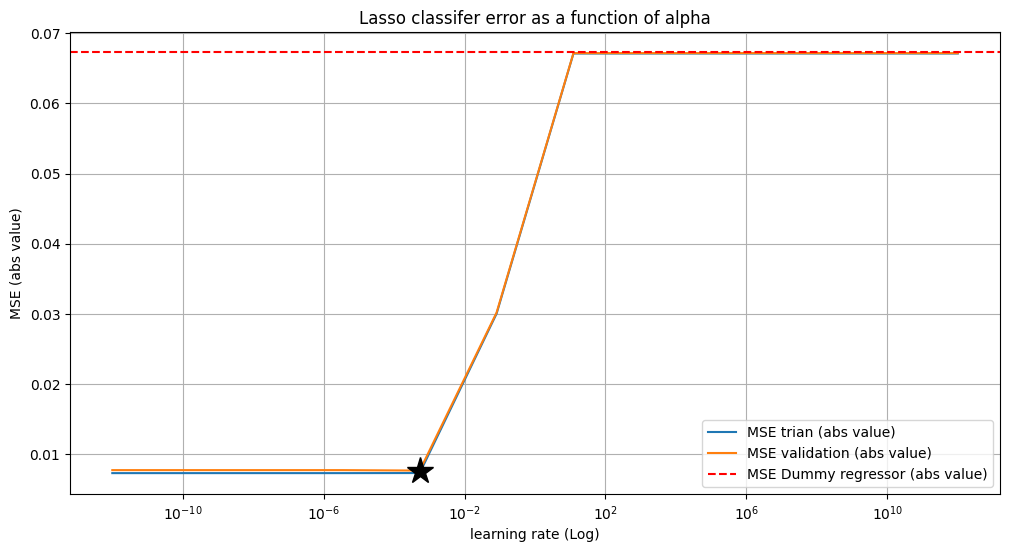

In [23]:
from sklearn.linear_model import Lasso
from matplotlib.pyplot import semilogx

scores_train, scores_val =[], []
best_train, best_val, best_alpha = -100, -100, 0
poss_values_alpha = np.logspace(-12, 12, 12)

for i in poss_values_alpha:
  cur_lasso = model = Lasso(alpha=i, fit_intercept=True)
  scores = cross_validate(cur_lasso, X_new_train, y_new_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_MSE = np.mean(scores['train_score'])
  val_MSE = np.mean(scores['test_score'])
  scores_train.append(train_MSE)
  scores_val.append(val_MSE)
  if val_MSE > best_val:
    best_train = train_MSE
    best_val = val_MSE
    best_alpha = i

cv_stat = pd.DataFrame(data={'alpha': poss_values_alpha})
cv_stat['Train MSE'] = np.array(scores_train).tolist()
cv_stat['Validation MSE'] =np.array(scores_val).tolist()

fig = plt.figure(figsize=(12, 6))
plt.semilogx(cv_stat['alpha'], abs(cv_stat['Train MSE']), '-', label="MSE trian (abs value)")
plt.semilogx(cv_stat['alpha'], abs(cv_stat['Validation MSE']), '-', label="MSE validation (abs value)")
plt.semilogx(cv_stat['alpha'][np.argmin(abs(cv_stat['Validation MSE']))], abs(cv_stat['Validation MSE'][np.argmin(abs(cv_stat['Validation MSE']))]), marker='*', markersize = 20, color='black')
plt.axhline(y=abs(dummy_reg_val_err),linestyle='--', label="MSE Dummy regressor (abs value)", color='r')
plt.title("Lasso classifer error as a function of alpha")
plt.xlabel("learning rate (Log)")
plt.ylabel("MSE (abs value)")
plt.grid(True)
plt.legend()

In [24]:
print("best_train_error is:", abs(best_train))
print("best_val_error is:", abs(best_val))
print("best_alpha is:", best_alpha)

best_train_error is: 0.007321486823643697
best_val_error is: 0.007675139292402417
best_alpha is: 0.0005336699231206301


## **Q8**

In [25]:
errors_data.loc["Lasso Linear"] = ['3', abs(best_train), abs(best_val)]
errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.066927,0.067375
Linear,2,0.007323,0.007732
Lasso Linear,3,0.007321,0.007675


In [26]:
lasso_linear_reggressor = Lasso(alpha=best_alpha, fit_intercept=True)
lasso_linear_reggressor.fit(X_new_train, y_new_train)

Lasso(alpha=0.0005336699231206301)

## **Q9**

In [27]:
X_new_train = train_df_prepared[features]
coefs = lasso_linear_reggressor.coef_
# print(coefs)
lasso_coefs ={'feature': X_new_train.columns.values, 'coef':coefs, 'abs coef':np.abs(coefs)}

sorted_coefs = pd.DataFrame(lasso_coefs).sort_values(by='abs coef', ascending=False)
print(sorted_coefs)

sorted_lst = sorted(enumerate(coefs), key=lambda x: abs(x[1]), reverse=True)
# print(sorted_lst)


                  feature      coef  abs coef
12                 PCR_04  0.194193  0.194193
7            sugar_levels  0.128961  0.128961
10                 PCR_02 -0.080314  0.080314
14                 PCR_06 -0.050900  0.050900
0                     age -0.014185  0.014185
17                 PCR_09 -0.007894  0.007894
11                 PCR_03 -0.004507  0.004507
1                     sex -0.002489  0.002489
19        SpecialProperty -0.001592  0.001592
9                  PCR_01  0.001407  0.001407
2                  weight  0.001235  0.001235
4         happiness_score -0.001235  0.001235
6   conversations_per_day -0.001065  0.001065
5        household_income  0.000809  0.000809
8          sport_activity  0.000683  0.000683
16                 PCR_08  0.000622  0.000622
3         num_of_siblings  0.000450  0.000450
15                 PCR_07 -0.000128  0.000128
13                 PCR_05  0.000000  0.000000
18                 PCR_10  0.000000  0.000000


## **Q10**

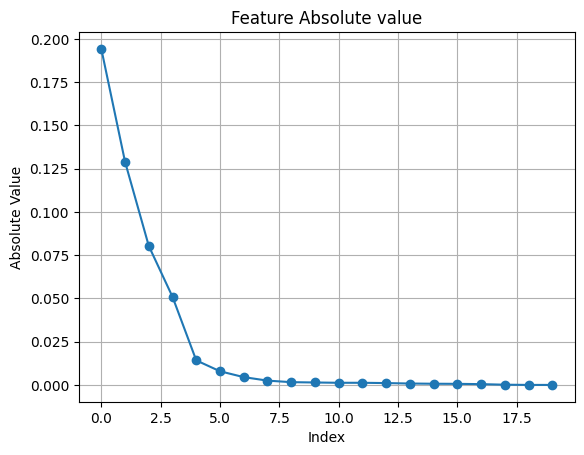

In [28]:
sorted_abs_coefs = sorted(abs(coefs), reverse=True)
plt.plot(range(len(sorted_abs_coefs)), sorted_abs_coefs, marker='o')

plt.xlabel('Index')
plt.ylabel('Absolute Value')
plt.title('Feature Absolute value')
plt.grid(True)
plt.show()

# **Section 4: Polynomial fitting (Visualization)**

In [29]:
X_train_subset = train_df_prepared[['PCR_04', 'PCR_06']].values
y_train_subset = train_df_prepared['contamination_level'].values

In [30]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

<ipython-input-30-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


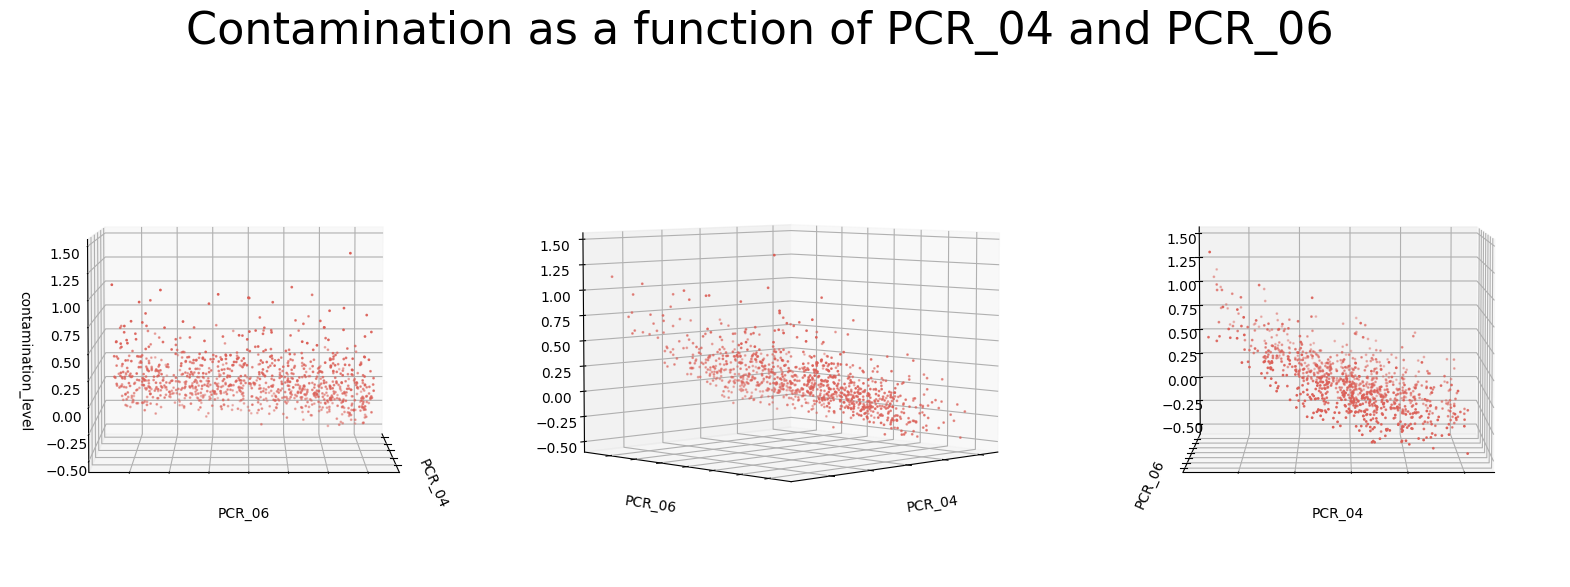

In [31]:
plot3d(train_df_prepared, 'PCR_04', 'PCR_06', 'contamination_level', 'Contamination as a function of PCR_04 and PCR_06')

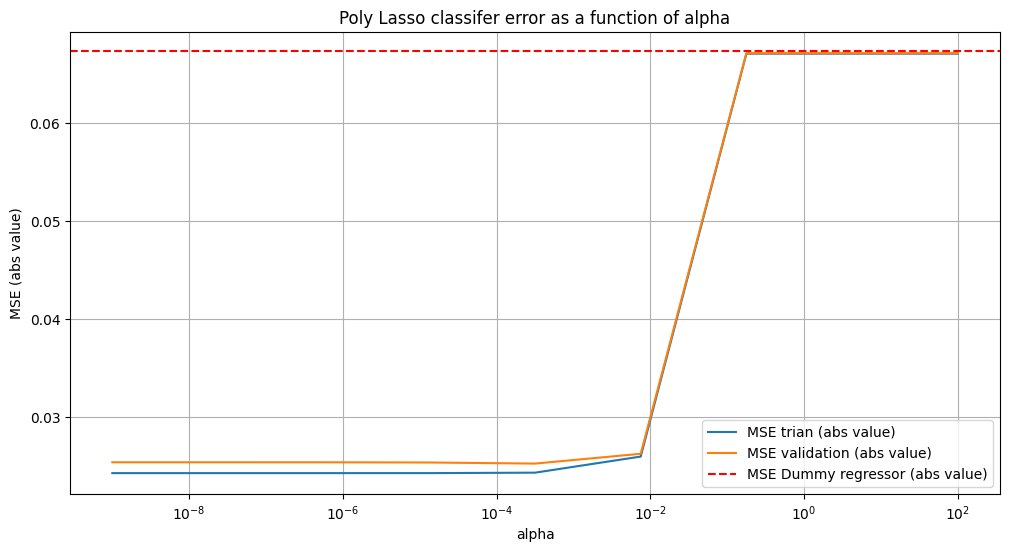

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

poss_vals_pip_alpha= np.logspace(-9, 2, 9)
best_train, best_val, best_alpha = -100, -100, 0
scores_train, scores_val =[], []
for i in poss_vals_pip_alpha:
  curr_poly = Pipeline([('feature_mapping', PolynomialFeatures(degree=4)), ('normalization', MinMaxScaler((-1,1))), ('Lasso', Lasso(alpha=i, fit_intercept=True))])
  scores = cross_validate(curr_poly, X_train_subset, y_train_subset, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_MSE = np.mean(scores['train_score'])
  val_MSE = np.mean(scores['test_score'])
  scores_train.append(train_MSE)
  scores_val.append(val_MSE)
  if val_MSE > best_val:
    best_train = train_MSE
    best_val = val_MSE
    best_alpha = i

cv_stat = pd.DataFrame(data={'alpha': poss_vals_pip_alpha})
cv_stat['Train MSE'] = np.array(scores_train).tolist()
cv_stat['Validation MSE'] =np.array(scores_val).tolist()

fig = plt.figure(figsize=(12, 6))
plt.semilogx(cv_stat['alpha'], abs(cv_stat['Train MSE']), '-', label="MSE trian (abs value)")
plt.semilogx(cv_stat['alpha'], abs(cv_stat['Validation MSE']), '-', label="MSE validation (abs value)")
plt.axhline(y=abs(dummy_reg_val_err),linestyle='--', label="MSE Dummy regressor (abs value)", color='r')
plt.title("Poly Lasso classifer error as a function of alpha")
plt.xlabel("alpha")
plt.ylabel("MSE (abs value)")
plt.grid(True)
plt.legend()

In [33]:
print("best_train_error is:", abs(best_train))
print("best_val_error is:", abs(best_val))
print("best_alpha is:", best_alpha)

best_train_error is: 0.024339720701781482
best_val_error is: 0.02526782046802236
best_alpha is: 0.00031622776601683794


In [34]:
X_train_subset = train_df_prepared[['PCR_04', 'PCR_06']].values
y_train_subset = train_df_prepared['contamination_level'].values
poly_lasso_regressor = Pipeline([('feature_mapping', PolynomialFeatures(degree=4)), ('normalization', MinMaxScaler((-1,1))), ('Lasso', Lasso(alpha=best_alpha, fit_intercept=True))])
poly_lasso_regressor.fit(X_train_subset, y_train_subset)
poly_lasso_preds= poly_lasso_regressor.predict(X_train_subset)


<ipython-input-30-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


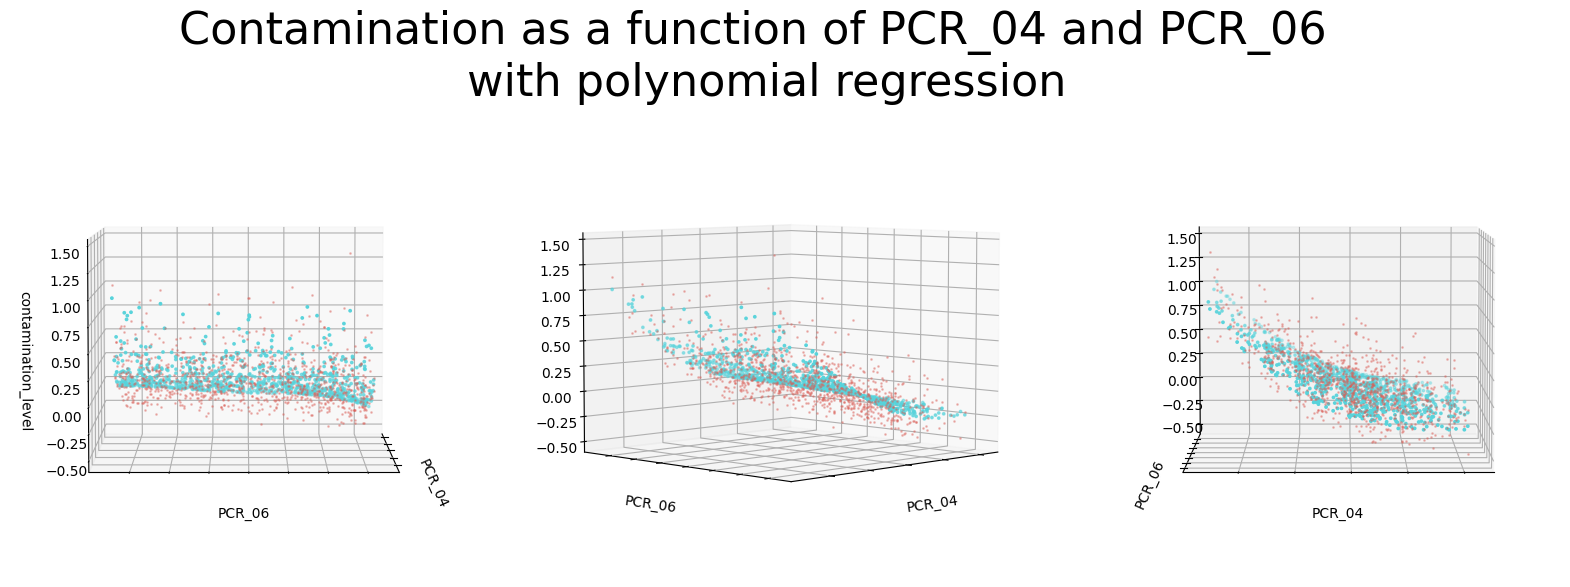

In [35]:
plot3d(train_df_prepared, 'PCR_04', 'PCR_06', 'contamination_level', 'Contamination as a function of PCR_04 and PCR_06 \n with polynomial regression', predictions=poly_lasso_preds)

# **Section 5: Fitting Gradient Boosted Machines (GBM) of the CovidScore**

In [36]:
features_p5= ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels']
X_train_copy = train_df_prepared[features_p5].values
y_train_copy = train_df_prepared['contamination_level'].values

X_test_copy = test_df_prepared[features_p5].values
y_test_copy = test_df_prepared['contamination_level'].values


##**Q18**

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# GBM_regressor = GradientBoostingRegressor(loss='huber')

poss_lr_values = np.logspace(start=-5, stop=-1, num=5)
params = {'GBM_regressor__learning_rate':poss_lr_values, 'GBM_regressor__min_samples_leaf':[3, 5, 10, 30, 50]}
pipe = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)), ('normalization', MinMaxScaler((-1,1))),('GBM_regressor',GradientBoostingRegressor(loss='huber'))])

output_model = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
output_model.fit(X_train_copy, y_train_copy)

df = pd.DataFrame.from_dict(output_model.cv_results_)
best_params = output_model.best_params_
best_score = output_model.best_score_
print(f'The best parameters are {best_params}')
print(f'The best score is {best_score}')

The best parameters are {'GBM_regressor__learning_rate': 0.1, 'GBM_regressor__min_samples_leaf': 3}
The best score is -0.0013414602212152352


Text(0.5, 1.0, 'neg MSE as a function of lr and min_samples_leaf')

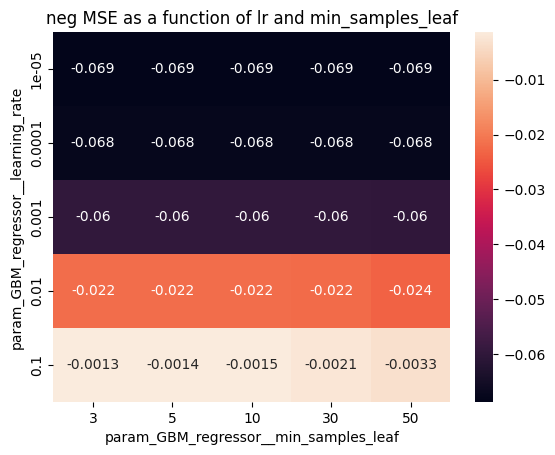

In [45]:
import seaborn as sns

test_pivot = pd.pivot_table(df, values='mean_test_score',index='param_GBM_regressor__learning_rate', columns='param_GBM_regressor__min_samples_leaf')
ax = sns.heatmap(test_pivot, annot=True)
ax.set_title('neg MSE as a function of lr and min_samples_leaf')

##**Q19**

In [46]:
train_MSE = np.max(output_model.cv_results_['mean_train_score'])
val_MSE = np.max(output_model.cv_results_['mean_test_score'])
errors_data.loc["GBM"] = ['5', abs(train_MSE), abs(val_MSE)]
errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.066927,0.067375
Linear,2,0.007323,0.007732
Lasso Linear,3,0.007321,0.007675
GBM,5,0.000294,0.001341


In [48]:
GBM_clf_p5 = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)), ('normalization', MinMaxScaler((-1,1))),('GBM_regressor',GradientBoostingRegressor(loss='huber',learning_rate=0.1, min_samples_leaf=3))])
X_train_copy = train_df_prepared[features_p5].values
y_train_copy = train_df_prepared['contamination_level'].values
GBM_clf_p5.fit(X_train_copy, y_train_copy)

Pipeline(steps=[('feature_mapping', PolynomialFeatures()),
                ('normalization', MinMaxScaler(feature_range=(-1, 1))),
                ('GBM_regressor',
                 GradientBoostingRegressor(loss='huber', min_samples_leaf=3))])

# **Section 6: Testing your models**

In [49]:
from sklearn.metrics import mean_squared_error
y_test = test_df_prepared['contamination_level']
X_test = test_df_prepared[features]
X_test_subset = test_df_prepared[['PCR_04', 'PCR_06']]
X_test_p = test_df_prepared[features_p5]
dummy_reg_y = dummy_regressor.predict(X_test)
linear_reg_y = linear_reggressor.predict(X_test)
linear_reg_lasso_y = lasso_linear_reggressor.predict(X_test)
ploy_lasso_reg_y = poly_lasso_regressor.predict(X_test_subset)
GBM_reg_y = GBM_clf_p5.predict(X_test_p)

MSE_res = {}
MSE_res['Dummy'] = abs(mean_squared_error(y_test, dummy_reg_y))
MSE_res['Linear'] = abs(mean_squared_error(y_test, linear_reg_y))
MSE_res['Lasso'] = abs(mean_squared_error(y_test, linear_reg_lasso_y))
MSE_res['Poly Lasso'] = abs(mean_squared_error(y_test, ploy_lasso_reg_y))
MSE_res['GBM'] = abs(mean_squared_error(y_test, GBM_reg_y))
MSE_res


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


{'Dummy': 0.07249366948131483,
 'Linear': 0.007632811383686941,
 'Lasso': 0.007599440372815742,
 'Poly Lasso': 0.02823277733658743,
 'GBM': 0.0013962055528093415}